# Predicting Taxi Fare

Reference: 
Loy, James. "Neural Network Projects With Python". Packt. Feb 2019.

## Dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Only contains first 0.5 million rows
df = pd.read_csv("/content/drive/My Drive/N/Projects/Taxi Fare/train.csv", parse_dates=['pickup_datetime'], nrows=500000)

In [0]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


- key: Contains same information as pickup_datetime column, which can be removed.
- fare_amount: The response variable we are trying to predict.
- pickup_datetime: yyyy-mm-dd hh:mm:ss district.
- pickup_longitude: the logitude pick up info.
- pickup_latitude: the latitude pick up info.
- dropoff_longitude: the longitude drop off info.
- dropoff_latitude: the latitude drop off info.
- passenger_count: the number of passengers.

In [0]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,499998.000000,499998.000000,499998.000000,499993.000000,499993.000000,499998.000000
mean,11.358383,-72.519952,39.920273,-72.522429,39.916522,1.683421
std,9.916630,11.856855,8.073491,11.797385,7.391017,1.307383
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992048,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


*   Approximate drop off longitude range: (-74.05, -73.75)
*   Approximate drop off latitude range: (40.7, 40.8) 




In [0]:
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75
nyc_min_latitude = 40.6
nyc_max_latitude = 40.85

In [0]:
df2 = df.copy(deep=True)
for long in ['pickup_longitude','dropoff_longitude']:
  df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] < nyc_max_longitude)]

for lat in ['pickup_latitude','dropoff_latitude']:
  df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] < nyc_max_latitude)]

Label landmarks in NYC

In [0]:
landmarks = {'JFK Ariport': (-73.78, 40.643),
        'LaGuardia Airport': (-73.87, 40.77),
        'Midtown': (-73.98, 40.76),
        'Lower Manhattan': (-74.00, 40.72),
        'Upper Manhattan': (-73.94, 40.82),
        'Brooklyn': (-73.95, 40.66)
}

## Data Visualization

Pick up drop off location plot (default=pick up)

In [0]:
def plot_lat_long(df, landmarks, points='Pickup'):
  plt.figure(figsize=(12,12))
  if points == 'Pickup':
    plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), '.', markersize=1)
  else:
    plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), '.', markersize=1)
  
  for landmark in landmarks:
    plt.plot(landmarks[landmark][0], landmarks[landmark][1], '*', markersize=15, alpha=1, color='r')
    plt.annotate(landmark, (landmarks[landmark][0]+0.005, landmarks[landmark][1]+0.005), color='r', backgroundcolor='w')
  
  plt.title("{} Location in NYC Illustrated".format(points))
  plt.grid(False)
  plt.xlabel("Latitude")
  plt.ylabel("Longitude")
  plt.show()

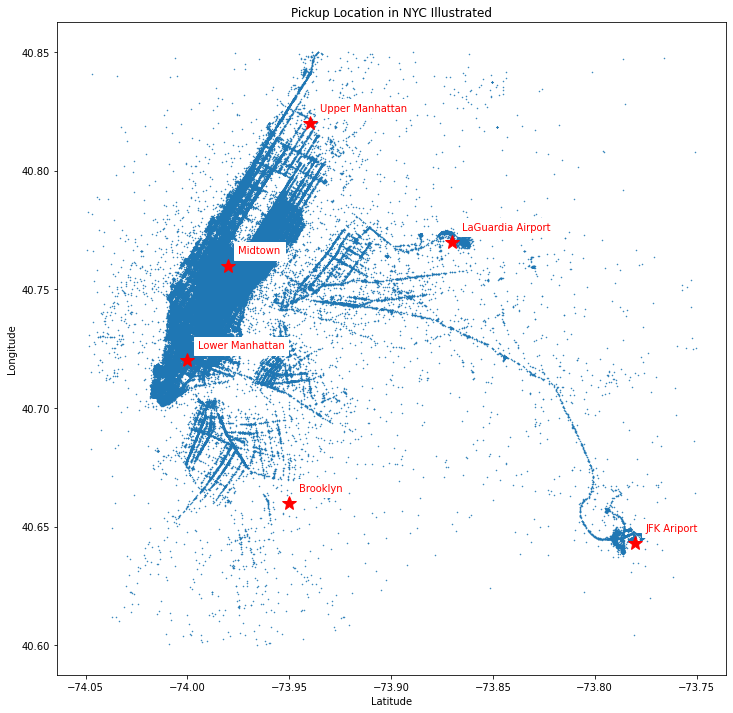

In [0]:
plot_lat_long(df2, landmarks, points='Pickup')



*   In Manhattan, most pickups are around the Midtown area, followed by Lower Manhattan. Comparing with Upper Manhattan which is a residential area, it has fewer pick ups.
*   Outside Manhattan pick ups locations are pretty sparse. Except the LaGuardia Airport and JFK Airport.



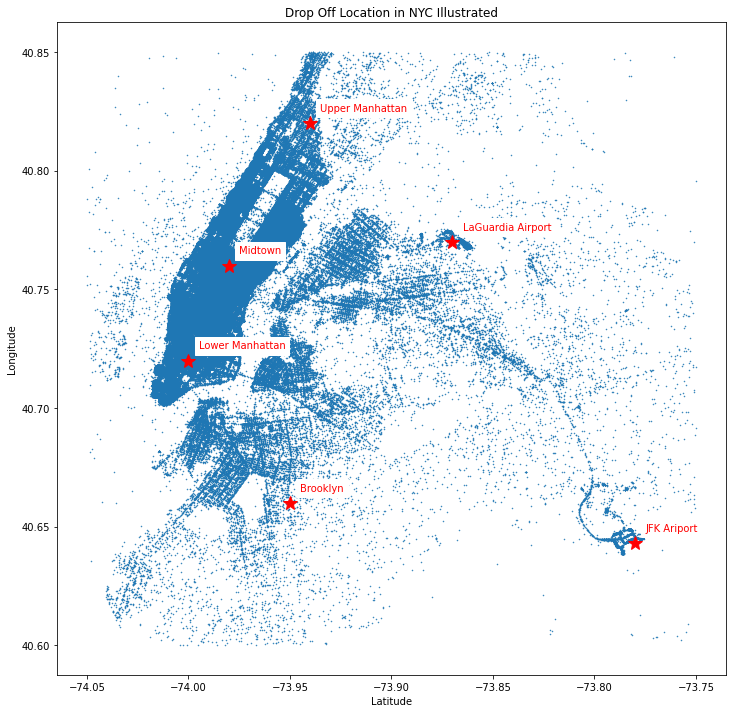

In [0]:
plot_lat_long(df2, landmarks, points='Drop Off')



*   More drop offs in Upper Manhattan area than pickups




In [0]:
df['year']=df['pickup_datetime'].dt.year # dt function
df['month']=df['pickup_datetime'].dt.month
df['day']=df['pickup_datetime'].dt.day
df['day_of_week']=df['pickup_datetime'].dt.dayofweek
df['hour']=df['pickup_datetime'].dt.hour

In [0]:
# np.arange(8)-0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5])

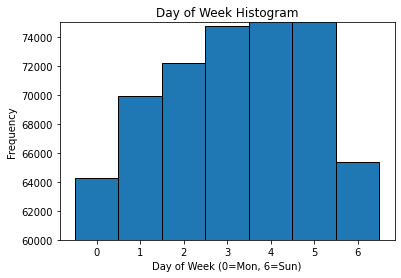

In [0]:
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black', ylim=(60000, 75000))
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.title('Day of Week Histogram')
plt.show()

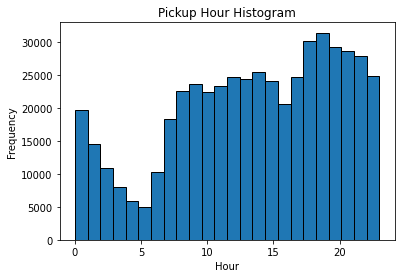

In [0]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

## Data Preprocessing

### Missing value

In [0]:
print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64


In [0]:
df=df.dropna()

In [0]:
print(df.describe())

         fare_amount  pickup_longitude  ...    day_of_week           hour
count  499993.000000     499993.000000  ...  499993.000000  499993.000000
mean       11.358205        -72.520085  ...       3.042033      13.510827
std         9.916082         11.856470  ...       1.949237       6.511595
min       -44.900000      -2986.242495  ...       0.000000       0.000000
25%         6.000000        -73.992048  ...       1.000000       9.000000
50%         8.500000        -73.981785  ...       3.000000      14.000000
75%        12.500000        -73.967117  ...       5.000000      19.000000
max       500.000000       2140.601160  ...       6.000000      23.000000

[8 rows x 11 columns]


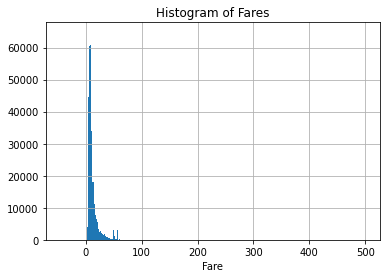

In [0]:
df['fare_amount'].hist(bins=500)
plt.xlabel('Fare')
plt.title("Histogram of Fares")
plt.show()

Remove outliers, values < $0 and > $100

In [0]:
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 100)]

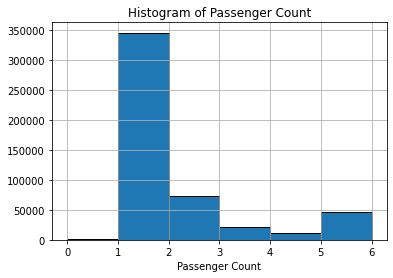

In [0]:
df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel('Passenger Count')
plt.title('Histogram of Passenger Count')
plt.show()

There's small amount passenger counts = 0, we change it to 1.

In [0]:
df.loc[df['passenger_count']==0, 'passenger_count'] = 1

Check the outliers of pickup and drop off locations

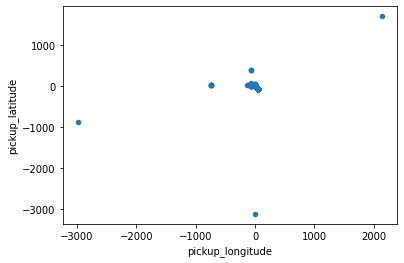

In [0]:
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()